In [187]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# method = 'Weighted'
# y_col = 'cost_var'
# l_val = "0.5"
# expmt = "50_151_0.1_0.1_uniform_uniform_False_0.0_3"
# weighted = pd.read_csv('./results/abalone/Weighted/' + expmt + '/results_df')
# afasmc = pd.read_csv('./results/abalone/AFASMC/' + expmt + '/results_df')
# rand = pd.read_csv('./results/abalone/Rand/'  + expmt + '/results_df')
# rand = rand[rand['acq_model'] == 'Rand']
# weighted = weighted[weighted['acq_model'] == 'Weighted']
# abalone = pd.concat([weighted, afasmc, rand])
# sns.lineplot(x='n_available', y=y_col, hue='acq_model', data=abalone, marker='o')


# if y_col == 'cost_mean':
#     plt.ylabel("Mean Cost per User")
#     plt.title("Abalone: Mean Collection Cost over Time")
# elif y_col == 'cost_var':
#     plt.ylabel("Variance in Cost across Users")
#     plt.title("Abalone: Collection Cost Variance over Time")
# elif y_col == 'mse':
#     plt.ylabel("MSE")
#     plt.title("Abalone: MSE over Time")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


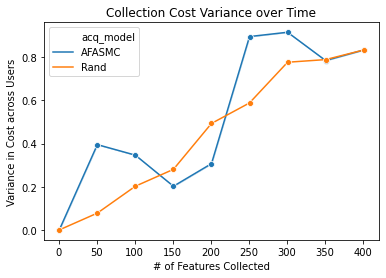

In [50]:
y_col = 'cost_var'
iris = pd.concat([pd.read_csv('./results/iris/AFASMC/results_df'), 
                       pd.read_csv('./results/iris/Rand/results_df')])
iris['n_collected'] = iris['n_available'] - 60
#sns.lineplot(x='n_collected', y='cost_mean', hue='acq_model', data=iris, marker='o')
sns.lineplot(x='n_collected', y=y_col, hue='acq_model', data=iris, marker='o')
plt.xlabel("# of Features Collected")

if y_col == 'cost_mean':
    plt.ylabel("Mean Cost per User")
    plt.title("Mean Collection Cost over Time")
elif y_col == 'cost_var':
    plt.ylabel("Variance in Cost across Users")
    plt.title("Collection Cost Variance over Time")
elif y_col == 'mse':
    plt.ylabel("MSE")
    plt.title("MSE over Time")

# How do different types of randomness affect performance of AFA methods?

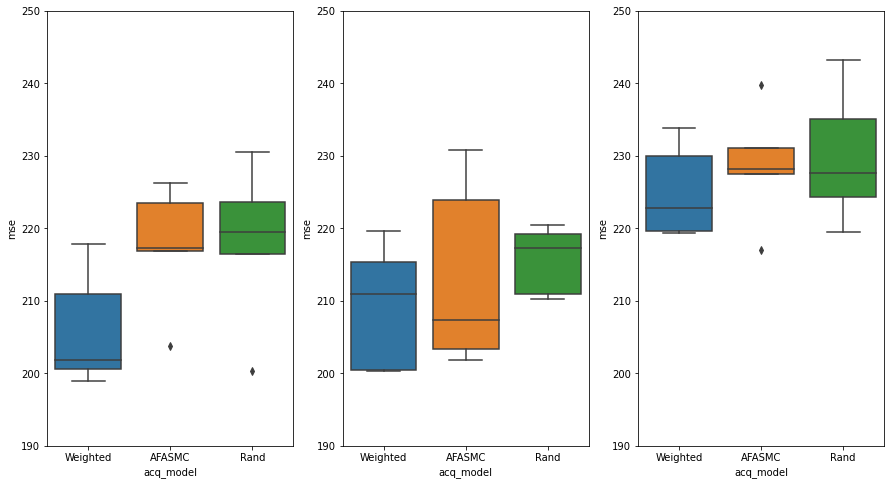

In [41]:
expmts = ["151_0.1_0.1_uniform_0.5_0.5_uniform_0.0_False_50_5",
          "151_0.1_0.1_users_0.5_0.5_uniform_0.0_False_50_5", 
          "151_0.1_0.1_features_0.5_0.5_uniform_0.0_False_50_5"]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 8))
for i, expmt in enumerate(expmts):
    weighted = pd.read_csv('./results/abalone/Weighted/' + expmt + '/results_df')
    afasmc = pd.read_csv('./results/abalone/AFASMC/' + expmt + '/results_df')
    rand = pd.read_csv('./results/abalone/Rand/'  + expmt + '/results_df')

    abalone = pd.concat([weighted, afasmc, rand])

    abalone = abalone[abalone['n_available'] == 3392]
    sns.boxplot(x='acq_model', y='mse', data=abalone, ax=axes[i])
    axes[i].set_ylim(190, 250)

# # Features compromised vs Performance

In [35]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from utils.dataset_helpers import get_dataset
from alipy.query_strategy.query_features import IterativeSVD_mc

dataset_name = "abalone"
methods = ['Weighted_usr']
expmt = "601_0.1_0.2_uniform_0.5_0.5_uniform_0.0_False_20_1000_3"
fpaths = ['results/' + dataset_name + '/' + method + '/' + expmt + '/' + 'observed_mats.pkl' for method in methods]
results = [pickle.load(open(fpath, 'rb')) for fpath in fpaths]

In [36]:
def get_user_cost(dataset_name, observed_idxs):
    data = get_dataset(dataset_name)
    n_users = data.shape[0]
    user_cost = np.zeros(n_users)
    user_feature_map = []
    for idx in observed_idxs:
        user_cost[idx[0]] += 1
    
    return user_cost

def impute(mat, observed_idxs):
    observed_mask = np.zeros(mat.shape)
    for idx in observed_idxs:
        observed_mask[idx[0], idx[1]] = 1
    
    svd_mc = IterativeSVD_mc(rank=3)
    imputed_mat = svd_mc.impute(mat, observed_mask=observed_mask)
    return imputed_mat

def get_user_performance(dataset_name, observed_idxs):
    mat = get_dataset(dataset_name)
    n_users = mat.shape[0]
    # create observed matrix
    observed_mat = np.zeros(mat.shape)
    for idx in observed_idxs:
        observed_mat[idx[0], idx[1]] = mat[idx[0], idx[1]]
    
    # select test idxs
    test_feats_per_user = []
    n_eval_idxs = 2
    for i in range(n_users):
        unknown = np.where(observed_mat[i] == 0)[0]
        try:
            feats = np.random.choice(unknown, n_eval_idxs, replace=False)
            test_feats_per_user.append(feats)
        except:
            test_feats_per_user.append([])
    # matrix completion
    completed_mat = impute(mat, observed_idxs)
    
    # calculate user cost
    user_perf = []
    for i,idxs in zip(range(n_users), test_feats_per_user):
        if len(idxs) == 0:
            user_perf.append(-1)
            continue
        # I want to compare the test idxs in the completed_mat to the mat
        # and calculate the mse per user
        diff = completed_mat[i,idxs] - mat [i,idxs]
        perf = np.mean(np.square(diff))
        user_perf.append(perf)
    return np.sqrt(np.array(user_perf))

Text(0.5, 1.0, 'abalone \n Relationship b/t User Privacy (# Features Collected) \n and User Performance (RMSE)')

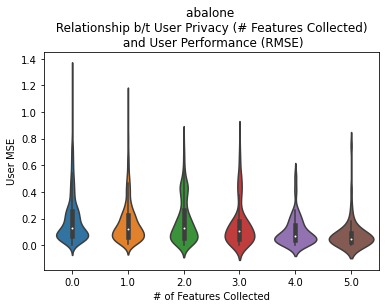

In [37]:
import seaborn as sns
from utils.dataset_helpers import get_dataset
observed_idxs = results[0][4]
user_perf = get_user_performance(dataset_name, observed_idxs)
user_cost = get_user_cost(dataset_name, observed_idxs)
user_idxs = np.where(user_cost < 6)[0]
user_perf = user_perf[user_idxs]
user_cost = user_cost[user_idxs]
#plt.scatter(user_cost, user_perf, alpha=.2)
# for i in range(8):
#     plt.hist(user_perf[np.where(user_cost == i)[0]], bins=np.arange(0, 1.4, .1), label=str(i))
# plt.legend()
sns.violinplot(user_cost, user_perf)
plt.xlabel("# of Features Collected")
plt.ylabel("User MSE")
plt.title(dataset_name + " \n Relationship b/t User Privacy (# Features Collected) \n and User Performance (RMSE)")

In [38]:
np.mean(user_perf)

0.17997199390967114

In [114]:
from scipy.stats import pearsonr
pearsonr(user_cost, user_perf)

(-0.04487205259261305, 0.0037237652429358567)

array([[ 7.4 ,  0.7 ,  0.  , ...,  0.56,  9.4 ,  5.  ],
       [ 7.8 ,  0.88,  0.  , ...,  0.68,  9.8 ,  5.  ],
       [ 7.8 ,  0.76,  0.04, ...,  0.65,  9.8 ,  5.  ],
       ...,
       [ 6.5 ,  0.24,  0.19, ...,  0.46,  9.4 ,  6.  ],
       [ 5.5 ,  0.29,  0.3 , ...,  0.38, 12.8 ,  7.  ],
       [ 6.  ,  0.21,  0.38, ...,  0.32, 11.8 ,  6.  ]], dtype=float32)

# Are the # of users exploited different over initialization?

In [248]:
dataset_name = 'wine_quality'
user_costs = [get_user_cost(dataset_name, idxs) for idxs in results[0]]

Text(0.5, 0, '# of Features Collected')

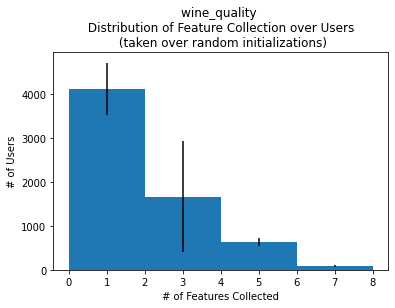

In [249]:
buckets = []
for i in range(5):
    bucket_vals = [0, 0, 0, 0]
    bucket_vals[0] = len(np.where(user_costs[i] < 2)[0])
    bucket_vals[1] = len(np.where((user_costs[i] >= 2) & (user_costs[i] < 4))[0])
    bucket_vals[2] = len(np.where((user_costs[i] >= 4) & (user_costs[i] < 6))[0])
    bucket_vals[3] = len(np.where((user_costs[i] >= 6) & (user_costs[i] <= 8))[0])
    buckets.append(bucket_vals)

bincenters = [1, 3, 5, 7]
buckets = np.array(buckets)
plt.bar(bincenters, np.mean(buckets, axis=0), yerr=np.var(buckets, axis=0), width=2)
plt.title(dataset_name + " \n Distribution of Feature Collection over Users \n (taken over random initializations)")
plt.ylabel("# of Users")
plt.xlabel("# of Features Collected")
# plot mean # of users in each bucket
# plot std dev of # of users in each bucket

# Are the users exploited different over different initializations?

In [255]:
# find user idxs corresponding with > 4 features collected across different runs
# see how much these sets overlap w one another
exploited_idxs = []
for i in range(5):
    exploited = np.where(user_costs[i] > 6)[0]
    exploited_idxs.append(exploited)

In [256]:
jj = [set(idxs) for idxs in exploited_idxs]
[[len(jj[i].intersection(x)) for x in jj] for i in range(5)]

[[11, 1, 0, 0, 0],
 [1, 14, 0, 0, 0],
 [0, 0, 11, 0, 0],
 [0, 0, 0, 10, 0],
 [0, 0, 0, 0, 15]]

In [258]:
len(set(np.concatenate(exploited_idxs))), len(np.concatenate(exploited_idxs))

(60, 61)

In [135]:
dataset_name

'abalone'

(array([  27.,   90.,  469.,  261., 1277., 1170.,  623.,  933.,   68.,
          45.]),
 array([-18.01422273, -15.47502226, -12.93582179, -10.39662132,
         -7.85742085,  -5.31822038,  -2.77901991,  -0.23981943,
          2.29938104,   4.83858151,   7.37778198]),
 <a list of 10 Patch objects>)

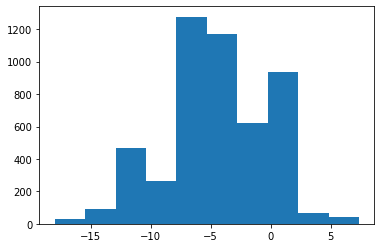

In [168]:
plt.hist(np.log(np.loadtxt('uncertainty')))

(array([ 158.,  208.,  176.,  147.,  248.,  597.,  471.,  872., 1223.,
         863.]),
 array([1.03790279, 1.30719633, 1.57648987, 1.8457834 , 2.11507694,
        2.38437048, 2.65366401, 2.92295755, 3.19225108, 3.46154462,
        3.73083816]),
 <a list of 10 Patch objects>)

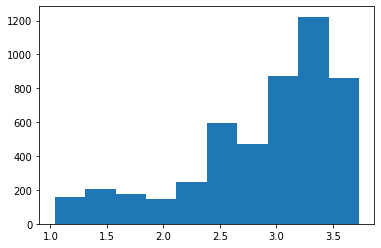

In [169]:
plt.hist(np.loadtxt('privacy'))

In [157]:
np.argsort(np.loadtxt('privacy'))
# index of each element in increasing order

array([4962, 4961, 4958, ..., 1995, 1997, 1998])

(array([  23.,   45.,  385.,  295.,  867., 1692.,  655.,  916.,   65.,
          20.]),
 array([-19.71299146, -17.05091678, -14.38884211, -11.72676743,
         -9.06469276,  -6.40261809,  -3.74054341,  -1.07846874,
          1.58360593,   4.24568061,   6.90775528]),
 <a list of 10 Patch objects>)

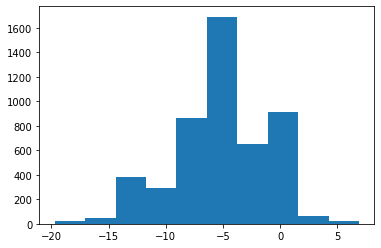

In [166]:
plt.hist(np.log(np.loadtxt('uncertainty')*1000))

In [175]:
def normalize(vals):
    min_val = np.min(vals) + 1e-10
    max_val = np.max(vals)
    norm_vals =(vals - min_val)/(max_val-min_val)
    return norm_vals

/home/t-sdivya/.conda/envs/dm/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
/home/t-sdivya/.conda/envs/dm/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6630: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/t-sdivya/.conda/envs/dm/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6631: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

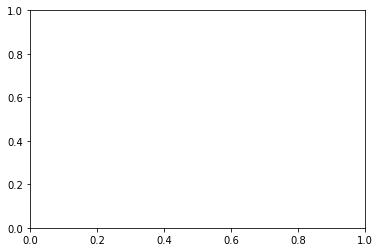

In [186]:
v = normalize(np.log(np.loadtxt('uncertainty')))
p = normalize(np.loadtxt('privacy'))
plt.hist(v, alpha=.5)
plt.hist(p, alpha=.5)

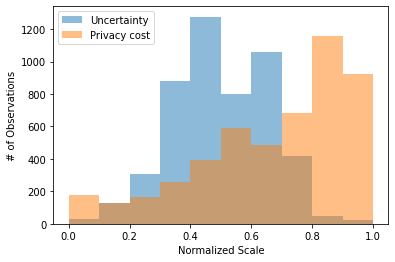

In [230]:
v = np.loadtxt('uncertainty')
p = np.loadtxt('privacy')
plt.hist(v, alpha=.5, label='Uncertainty')
plt.hist(p, alpha=.5, label='Privacy cost')
plt.xlabel("Normalized Scale")
plt.ylabel("# of Observations")
plt.legend()

In [185]:
v[np.argsort(v)[-10:]], p[np.argsort(v)[-10:]]

(array([0.98630577, 0.98631257, 0.98733544, 0.99368062, 0.99500198,
        0.99540169, 0.99696227, 0.99707413, 0.99986813, 1.        ]),
 array([0.56379728, 0.97199788, 0.93050348, 0.48946148, 0.97430268,
        0.52168328, 0.92895982, 0.38931086, 0.49333664, 0.90121676]))